# <span style="color:lightblue">PREDICTING BANK PRODUCT SUBSCRIPTION</span>

Authors:

- Miguel Ramos Cabañas 100473854

- Miguel Rodríguez Losada 100568756

##  <span style="color:#0066CC">Libraries Import</span>

Before starting the analysis, we first import all the libraries we’ll need throughout the assignment.
These include basic tools for working with data (like pandas and numpy), plotting (matplotlib), and building machine-learning models (scikit-learn).
Having all the imports together at the beginning keeps the notebook organized and makes it easier to see which tools we are using.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.proportion import proportion_confint

##  <span style="color:#0066CC"> Data Import</span>

We use the last 2 digits from the NIA from the first author. As a consequence, we select the data folder **bank_54**.

For convenience and ease of manipulation, the data are loaded into a pandas DataFrame.


In [2]:
data = pd.read_pickle("P1_assignment_dataset_bank_ALL/bank_54.pkl")

print(data.head())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


##  <span style="color:#0066CC"> Simplified EDA</span>

Before exploring the data, it is useful to understand what each variable represents.
The table below summarizes all the columns in the dataset, including client information, campaign details, and the target variable deposit.

| Variable | Short Description |
| :--- | :--- |
| **age** | age in years |
| **job** | type of job |
| **marital** | marital status |
| **education** | education level |
| **default** | has credit in default? |
| **balance** | average yearly balance |
| **housing** | has a housing loan? |
| **loan** | has a personal loan? |
| **contact** | contact communication type |
| **day_of_week** | last contact day |
| **month** | last contact month |
| **duration** | last contact duration, in seconds |
| **campaign** | number of contacts performed during this campaign and for this client |
| **pdays** | number of days that passed by after the client was last contacted from a previous campaign. The value is -1 if no/unknown contact was produced. |
| **previous** | number of contacts performed before this campaign and for this client |
| **poutcome** | outcome of the previous marketing campaign |
| **deposit** | has the client subscribed a term deposit? **TARGET VARIABLE** |

To begin the exploratory analysis, we first determine the size of the dataset by identifying the total number of instances (rows) and features (columns).

In [17]:
print("The number of instances (rows) in the dataset is", len(data), "and the number of features (columns) is", len(data.columns))

The number of instances (rows) in the dataset is 11000 and the number of features (columns) is 17


Also, it is important to understand the type of each variable in the dataset.  
This helps us decide how to handle them later: for example, numerical features may require scaling, while categorical features need encoding.  

In the following step, we separate the variables into two groups:
- **Numerical variables** (integers or floats) 
- **Categorical variables** (strings or objects)

In [18]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical variables:", numerical_cols)
print("Categorical variables:", categorical_cols)

Numerical variables: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


In the following step, we compute the number of unique values for each categorical feature to detect potential high-cardinality columns.

In [19]:
unique_counts = {col: data[col].nunique() for col in categorical_cols}

print("Number of unique categories per categorical variable:")
for col, count in unique_counts.items():
    print(f"{col}: {count}")

Number of unique categories per categorical variable:
job: 12
marital: 3
education: 4
default: 2
housing: 2
loan: 2
contact: 3
month: 12
poutcome: 4
deposit: 2


We next examine the presence of missing values and identify any features that may need special treatment.  
Specifically, we check:
- whether any variables contain missing entries,
- whether any columns are constant (i.e., have only one unique value), and
- whether any column behaves like an identifier, containing a different value for every row.


In [20]:
missing_values = data.isna().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age            0
job            0
marital      538
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
deposit        0
dtype: int64


In [21]:
constant_cols = [col for col in data.columns if data[col].nunique() == 1]
print("\nConstant columns:")
print(constant_cols)


Constant columns:
[]


In [22]:
id_like_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("\nID-like columns:")
print(id_like_cols)


ID-like columns:
[]


From the missing-value analysis, we observe that all variables except one are complete.
The only feature containing missing data is **marital**, with 538 missing entries.
This means we will need to decide later whether to impute these values or apply another preprocessing strategy.

We also checked for constant columns, and none were found. This is good because it means every feature contributes at least some variability to the dataset.

Finally, there are no ID-like columns, so the dataset does not include fields that uniquely identify each row.
This confirms that all variables are potentially useful for modelling and that no column needs to be removed for behaving like an identifier.

After this initial inspection of the dataset, we can verify that the task corresponds to a **binary classification problem**, where the target variable deposit takes two possible values: yes or no.

The objective is to predict whether a client has subscribed to a term deposit based on the available features.

To verify whether the classification problem is imbalanced, we examine the class proportions of the target variable deposit.

This will be a key point to determine the strategy for the outer and inner evaluation.


In [23]:
data['deposit'].value_counts(normalize=True)


deposit
no     0.525455
yes    0.474545
Name: proportion, dtype: float64

The target variable shows a proportion of approximately 52.5% for "no" and 47.5% for "yes".  
This distribution is relatively balanced, meaning we do not need any special imbalanced-learning techniques.  

The variable `pdays` indicates the number of days since the client was last contacted in a previous campaign.  
A value of **–1** means the client was never contacted.  

In [24]:
print(data['pdays'].describe())

count    11000.000000
mean        51.308636
std        108.782842
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         20.250000
max        854.000000
Name: pdays, dtype: float64



Most values are –1, meaning the variable is highly skewed and not suitable as a standard numerical feature.  

A good strategy to simplify its interpretation, we create a binary variable:

- 1 → client was previously contacted  
- 0 → client was never contacted

This captures the relevant information without misinterpreting –1 as a real day count.

In [25]:
# Binary transformation of pdays
data['pdays_contacted'] = (data['pdays'] != -1).astype(int)

# Quick check
data['pdays_contacted'].value_counts()

pdays_contacted
0    8203
1    2797
Name: count, dtype: int64

##  <span style="color:#0066CC"> Definition of the outer and inner evaluation EDA</span>

%%%%% Teño que redactar aquí 

### Códigos ayuda

In [26]:
# 1. ANALYSIS FUNCTION 
def analyze_test_accuracy(data, target_col, test_sizes=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    """
    We analyze the effect of different test sizes on accuracy estimates using a decision tree.
    We return a DataFrame including estimated accuracy, Clopper-Pearson confidence intervals, and their widths.
    Note: This methology was extracted from the notion of Binomial/Beta distribution in Topic 3 for selecting optimal test size.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]


    # Identify categorical columns and apply OneHotEncoder
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    print("Applying OneHotEncoder...")
    X_array = preprocessor.fit_transform(X)

    # Attempt to retrieve feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        feature_names = [f"feat_{i}" for i in range(X_array.shape[1])]

    X = pd.DataFrame(X_array, columns=feature_names)

    results = []
    print(f"Analyzing dataset with {len(data)} total instances...\n")

    for test_size in test_sizes:
        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=100473854
        )

        # Fit a decision tree as a proxy model
        clf = DecisionTreeClassifier(random_state=100473854, max_depth=5)
        clf.fit(X_train, y_train)

        # Compute accuracy and confidence intervals
        y_pred = clf.predict(X_test)
        n_test = len(y_test)
        correct_predictions = np.sum(y_pred == y_test)
        accuracy = correct_predictions / n_test

        # Clopper-Pearson (Beta) confidence interval
        ci_low, ci_high = proportion_confint(correct_predictions, n_test, alpha=0.05, method='beta')
        width = ci_high - ci_low

        # We store exact numerical values to ensure plotting accuracy
        results.append({
            'Test Size %': int(test_size*100),
            'N Test': n_test,
            'N Train': len(y_train),
            'Accuracy Est.': accuracy,
            'CI Low': ci_low,
            'CI High': ci_high,
            'CI Width': width
        })

    return pd.DataFrame(results)


In [27]:
# 2. PLOTTING FUNCTION
def plot_results(df, optimal_pct=15):
    """
    We visualize the accuracy estimates and confidence intervals for different test sizes.
    The first plot shows uncertainty vs. test size; the second shows error bars for estimated accuracy.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # -- PLOT 1: Uncertainty Curve --
    sizes = df['Test Size %']
    widths = df['CI Width']
    ax1.plot(sizes, widths, marker='o', linestyle='-', color='gray', label='Interval Width')

    # Highlight the optimal test size
    row_opt = df[df['Test Size %'] == optimal_pct]
    if not row_opt.empty:
        val_width = row_opt['CI Width'].values[0]
        ax1.scatter(optimal_pct, val_width, color='red', s=150, zorder=5, label=f'Selection ({optimal_pct}%)')
        ax1.axvline(x=optimal_pct, color='red', linestyle='--', alpha=0.5)
        ax1.annotate(f'Width: {val_width:.4f}',
                     xy=(optimal_pct, val_width), xytext=(optimal_pct+2, val_width+0.01),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    ax1.set_title('Uncertainty vs. Test Size\n(Smaller Width is Better)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Test Size (%)')
    ax1.set_ylabel('Interval Width')
    ax1.legend()

    # -- PLOT 2: Error Bars for Accuracy --
    y_err_low = df['Accuracy Est.'] - df['CI Low']
    y_err_high = df['CI High'] - df['Accuracy Est.']
    error_bars = [y_err_low, y_err_high]
    colors = ['red' if s == optimal_pct else 'skyblue' for s in sizes]

    ax2.errorbar(sizes, df['Accuracy Est.'], yerr=error_bars, fmt='none', ecolor='gray', elinewidth=2, capsize=5)
    ax2.scatter(sizes, df['Accuracy Est.'], s=100, c=colors, zorder=3)

    ax2.set_title('Statistical Accuracy (Real Confidence Intervals)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Test Size (%)')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


Applying OneHotEncoder...
Analyzing dataset with 11000 total instances...

Results Table:
 Test Size %  N Test  N Train  Accuracy Est.      CI 95% Text  CI Width
           5     550    10450       0.796364 [0.7602, 0.8293]  0.069014
          10    1100     9900       0.792727 [0.7676, 0.8163]  0.048777
          15    1650     9350       0.800000 [0.7799, 0.8191]  0.039186
          20    2200     8800       0.807727 [0.7906, 0.8240]  0.033377
          25    2750     8250       0.818182 [0.8032, 0.8324]  0.029186
          30    3300     7700       0.815152 [0.8015, 0.8283]  0.026784

Generating plots...


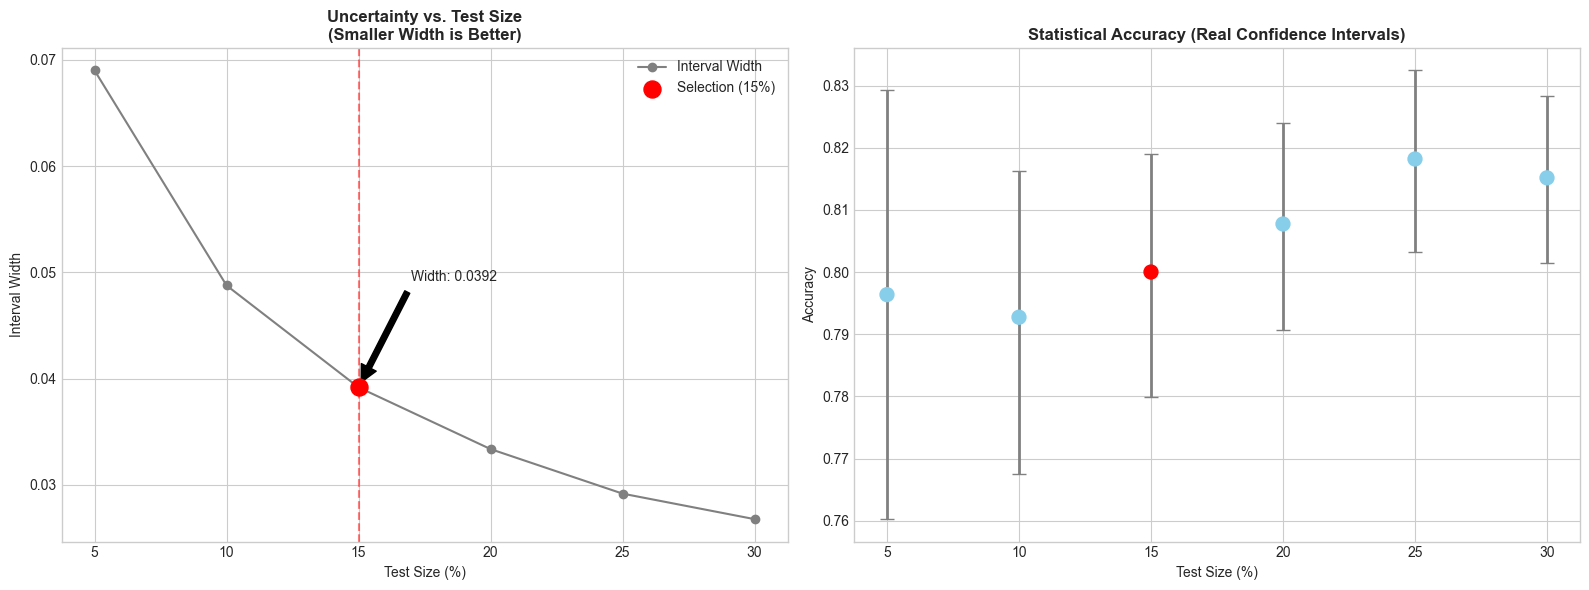

In [28]:
# MAIN EXECUTION
try:
    # 1. Run analysis (using the updated function above)
    df_res = analyze_test_accuracy(data, "deposit")  

    # 2. Print results table
    print("Results Table:")
    print_df = df_res.copy()
    print_df['CI 95% Text'] = print_df.apply(lambda x: f"[{x['CI Low']:.4f}, {x['CI High']:.4f}]", axis=1)
    cols_show = ['Test Size %', 'N Test', 'N Train', 'Accuracy Est.', 'CI 95% Text', 'CI Width']
    print(print_df[cols_show].to_string(index=False))

    # 3. Generate plots
    print("\nGenerating plots...")
    plot_results(df_res, optimal_pct=15)

except NameError:
    print("Error: Please ensure the variable 'data' is loaded before running.")
except Exception as e:
    print(f"An error occurred: {e}")

In [29]:
X = data.drop(columns='deposit') 
y = data['deposit']

# Split 85% train, 15% test: Optimal test size from analysis
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,  
    random_state=100473854, 
    stratify=y       
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)

Tamaño X_train: (9350, 17)
Tamaño X_test: (1650, 17)


## Basic Methods

### KNN

### TREES

## Advanced Methods

## Results and Final Model

## Probability Calibration

## Open Choice Task